In [1]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import tensorflow.compat.v1 as tf1
%matplotlib inline

In [2]:
!pip install efficientnet
import efficientnet.tfkeras as efn

     |████████████████████████████████| 50 kB 4.9 MB/s 


In [3]:
SEED = 42
np.random.seed(SEED)
tf1.set_random_seed(SEED)

In [4]:
from skimage.filters import rank, threshold_otsu
from skimage.color import rgb2grey
from sklearn.cluster import KMeans
from skimage.morphology import closing, square, disk

In [5]:
def plot_any(arr, title = ''):
    """
    plot multiple pictures
    """
    plt.figure(figsize = (15, 25))
    for i in range(len(arr)):
        plt.subplot(1,len(arr),i + 1)
        plt.title(title)
        plt.imshow(arr[i]);

        
def d2Kmeans(img, k):
    """
    Apply 2 dimensional KMeans algorithm on pictures
    """
    return KMeans(n_jobs=-1, 
                  random_state=1, 
                  n_clusters = k, 
                  init='k-means++'
    ).fit(img.reshape((-1,1))).labels_.reshape(img.shape)


def merge_segmented_mask_ROI(uri_img, img_kluster):
    """
    Merge original pricture and segmented picture
    """
    new_img = uri_img.copy()
    for ch in range(3):
        new_img[:,:, ch] *= img_kluster
    return new_img


def mean_filter(image, radius):
    """
    Create smooth boundaries of segmenation thourgh applying a gaussian mean blur
    """
    return rank.mean_percentile(image, selem = disk(radius))


def binary(image):
    """
    Get round boundaries of the image when segmenting
    """
    return image > threshold_otsu(image)


def select_cluster_index(clusters):
    """
    Chooose the right cluster index, which is the smallest, as the rest is background
    """
    minx = clusters[0].mean()
    index = 0
    for i in clusters:
        if i.mean() < minx:
            minx = i.mean()
            index += 1
    return index


def segment_image(img, k = 2):
    """
    segment the image in skin mole versus background
    """
    # Cluster the image
    result_gray = d2Kmeans(rgb2grey(img), k)
    
    # Select the correct cluster
    clusters_gray = [result_gray == i for i in range(k)]
    selected_index = select_cluster_index(clusters_gray)
    results_gray = clusters_gray[selected_index]
    
    # Apply smoothing of the boundaries
    image_mean_filter = mean_filter(results_gray, 20)
    test_binary = binary(image_mean_filter)
    
    # Create segmented picture with black background
    new_img = merge_segmented_mask_ROI(img, test_binary)
    
    return new_img

In [6]:
#Transfer 'jpg' images to an array IMG
DIR = '/content/drive/MyDrive/skincancer/data/test/benign'
benign_test = np.array([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])
print("number of benign test data:" + str(len(benign_test)))

# number of malignant test data
DIR = '/content/drive/MyDrive/skincancer/data/test/malignant'
malignant_test = np.array([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])
print("number of malignant test data:" + str(len(malignant_test)))

DIR = '/content/drive/MyDrive/skincancer/data/train/malignant'
malignant_train = np.array([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])
print("number of malignant train data:" + str(len(malignant_train)))

DIR = '/content/drive/MyDrive/skincancer/data/train/benign'
benign_train = np.array([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])
print("number of benign train data:" + str(len(benign_train)))

number of benign test data:360
number of malignant test data:300
number of malignant train data:1197
number of benign train data:1440


In [7]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malignant_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malignant_test))

# Merge data 
X_train = np.concatenate((benign_train, malignant_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malignant_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes= 2)
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes= 2)

In [8]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=SEED
)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Add Image augmentation to our generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=(0.75,1),
                                   brightness_range=(0.75,1.25)
                                  )

vtest_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/skincancer/data/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = vtest_datagen.flow_from_directory('/content/drive/MyDrive/skincancer/data/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [10]:
def build_model(backbone, lr=1e-4):
    model = tf.keras.Sequential()
    model.add(backbone)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(2, activation='softmax'))
    
    return model

In [11]:
from tensorflow.python.keras.optimizer_v2.optimizer_v2 import OptimizerV2

from tensorflow.python.ops.gen_math_ops import *
from tensorflow.python.keras import backend as K

__all__ = ['RAdam']


class RAdam(OptimizerV2):
    """RAdam optimizer.
    According to the paper
    [On The Variance Of The Adaptive Learning Rate And Beyond](https://arxiv.org/pdf/1908.03265v1.pdf).
    """

    def __init__(self,
                 learning_rate=0.001,
                 beta_1=0.9,
                 beta_2=0.999,
                 epsilon=1e-7,
                 weight_decay=0.,
                 amsgrad=False,
                 total_steps=0,
                 warmup_proportion=0.1,
                 min_lr=0.,
                 name='RAdam',
                 **kwargs):
        r"""Construct a new Adam optimizer.
        Args:
            learning_rate: A Tensor or a floating point value.    The learning rate.
            beta_1: A float value or a constant float tensor. The exponential decay
                rate for the 1st moment estimates.
            beta_2: A float value or a constant float tensor. The exponential decay
                rate for the 2nd moment estimates.
            epsilon: A small constant for numerical stability. This epsilon is
                "epsilon hat" in the Kingma and Ba paper (in the formula just before
                Section 2.1), not the epsilon in Algorithm 1 of the paper.
            weight_decay: A floating point value. Weight decay for each param.
            amsgrad: boolean. Whether to apply AMSGrad variant of this algorithm from
                the paper "On the Convergence of Adam and beyond".
            total_steps: An integer. Total number of training steps.
                Enable warmup by setting a positive value.
            warmup_proportion: A floating point value. The proportion of increasing steps.
            min_lr: A floating point value. Minimum learning rate after warmup.
            name: Optional name for the operations created when applying gradients.
                Defaults to "Adam".    @compatibility(eager) When eager execution is
                enabled, `learning_rate`, `beta_1`, `beta_2`, and `epsilon` can each be
                a callable that takes no arguments and returns the actual value to use.
                This can be useful for changing these values across different
                invocations of optimizer functions. @end_compatibility
            **kwargs: keyword arguments. Allowed to be {`clipnorm`, `clipvalue`, `lr`,
                `decay`}. `clipnorm` is clip gradients by norm; `clipvalue` is clip
                gradients by value, `decay` is included for backward compatibility to
                allow time inverse decay of learning rate. `lr` is included for backward
                compatibility, recommended to use `learning_rate` instead.
        """

        super(RAdam, self).__init__(name, **kwargs)
        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('beta_1', beta_1)
        self._set_hyper('beta_2', beta_2)
        self._set_hyper('decay', self._initial_decay)
        self._set_hyper('weight_decay', weight_decay)
        self._set_hyper('total_steps', float(total_steps))
        self._set_hyper('warmup_proportion', warmup_proportion)
        self._set_hyper('min_lr', min_lr)
        self.epsilon = epsilon or K.epsilon()
        self.amsgrad = amsgrad
        self._initial_weight_decay = weight_decay
        self._initial_total_steps = total_steps

    def _create_slots(self, var_list):
        for var in var_list:
            self.add_slot(var, 'm')
        for var in var_list:
            self.add_slot(var, 'v')
        if self.amsgrad:
            for var in var_list:
                self.add_slot(var, 'vhat')

    def set_weights(self, weights):
        params = self.weights
        num_vars = int((len(params) - 1) / 2)
        if len(weights) == 3 * num_vars + 1:
            weights = weights[:len(params)]
        super(RAdam, self).set_weights(weights)

    def _resource_apply_dense(self, grad, var):
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype)
        m = self.get_slot(var, 'm')
        v = self.get_slot(var, 'v')
        beta_1_t = self._get_hyper('beta_1', var_dtype)
        beta_2_t = self._get_hyper('beta_2', var_dtype)
        epsilon_t = ops.convert_to_tensor(self.epsilon, var_dtype)
        local_step = math_ops.cast(self.iterations + 1, var_dtype)
        beta_1_power = math_ops.pow(beta_1_t, local_step)
        beta_2_power = math_ops.pow(beta_2_t, local_step)

        if self._initial_total_steps > 0:
            total_steps = self._get_hyper('total_steps', var_dtype)
            warmup_steps = total_steps * self._get_hyper('warmup_proportion', var_dtype)
            min_lr = self._get_hyper('min_lr', var_dtype)
            decay_steps = K.maximum(total_steps - warmup_steps, 1)
            decay_rate = (min_lr - lr_t) / decay_steps
            lr_t = tf.where(
                local_step <= warmup_steps,
                lr_t * (local_step / warmup_steps),
                lr_t + decay_rate * K.minimum(local_step - warmup_steps, decay_steps),
            )

        sma_inf = 2.0 / (1.0 - beta_2_t) - 1.0
        sma_t = sma_inf - 2.0 * local_step * beta_2_power / (1.0 - beta_2_power)

        m_t = state_ops.assign(m,
                               beta_1_t * m + (1.0 - beta_1_t) * grad,
                               use_locking=self._use_locking)
        m_corr_t = m_t / (1.0 - beta_1_power)

        v_t = state_ops.assign(v,
                               beta_2_t * v + (1.0 - beta_2_t) * math_ops.square(grad),
                               use_locking=self._use_locking)
        if self.amsgrad:
            vhat = self.get_slot(var, 'vhat')
            vhat_t = state_ops.assign(vhat,
                                      math_ops.maximum(vhat, v_t),
                                      use_locking=self._use_locking)
            v_corr_t = math_ops.sqrt(vhat_t / (1.0 - beta_2_power))
        else:
            vhat_t = None
            v_corr_t = math_ops.sqrt(v_t / (1.0 - beta_2_power))

        r_t = math_ops.sqrt((sma_t - 4.0) / (sma_inf - 4.0) *
                            (sma_t - 2.0) / (sma_inf - 2.0) *
                            sma_inf / sma_t)

        var_t = tf.where(sma_t >= 5.0, r_t * m_corr_t / (v_corr_t + epsilon_t), m_corr_t)

        if self._initial_weight_decay > 0.0:
            var_t += self._get_hyper('weight_decay', var_dtype) * var

        var_update = state_ops.assign_sub(var,
                                          lr_t * var_t,
                                          use_locking=self._use_locking)

        updates = [var_update, m_t, v_t]
        if self.amsgrad:
            updates.append(vhat_t)
        return control_flow_ops.group(*updates)

    def _resource_apply_sparse(self, grad, var, indices):
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype)
        beta_1_t = self._get_hyper('beta_1', var_dtype)
        beta_2_t = self._get_hyper('beta_2', var_dtype)
        epsilon_t = ops.convert_to_tensor(self.epsilon, var_dtype)
        local_step = math_ops.cast(self.iterations + 1, var_dtype)
        beta_1_power = math_ops.pow(beta_1_t, local_step)
        beta_2_power = math_ops.pow(beta_2_t, local_step)

        if self._initial_total_steps > 0:
            total_steps = self._get_hyper('total_steps', var_dtype)
            warmup_steps = total_steps * self._get_hyper('warmup_proportion', var_dtype)
            min_lr = self._get_hyper('min_lr', var_dtype)
            decay_steps = K.maximum(total_steps - warmup_steps, 1)
            decay_rate = (min_lr - lr_t) / decay_steps
            lr_t = tf.where(
                local_step <= warmup_steps,
                lr_t * (local_step / warmup_steps),
                lr_t + decay_rate * K.minimum(local_step - warmup_steps, decay_steps),
            )

        sma_inf = 2.0 / (1.0 - beta_2_t) - 1.0
        sma_t = sma_inf - 2.0 * local_step * beta_2_power / (1.0 - beta_2_power)

        m = self.get_slot(var, 'm')
        m_scaled_g_values = grad * (1 - beta_1_t)
        m_t = state_ops.assign(m, m * beta_1_t, use_locking=self._use_locking)
        with ops.control_dependencies([m_t]):
            m_t = self._resource_scatter_add(m, indices, m_scaled_g_values)
        m_corr_t = m_t / (1.0 - beta_1_power)

        v = self.get_slot(var, 'v')
        v_scaled_g_values = (grad * grad) * (1 - beta_2_t)
        v_t = state_ops.assign(v, v * beta_2_t, use_locking=self._use_locking)
        with ops.control_dependencies([v_t]):
            v_t = self._resource_scatter_add(v, indices, v_scaled_g_values)

        if self.amsgrad:
            vhat = self.get_slot(var, 'vhat')
            vhat_t = state_ops.assign(vhat,
                                      math_ops.maximum(vhat, v_t),
                                      use_locking=self._use_locking)
            v_corr_t = math_ops.sqrt(vhat_t / (1.0 - beta_2_power))
        else:
            vhat_t = None
            v_corr_t = math_ops.sqrt(v_t / (1.0 - beta_2_power))

        r_t = math_ops.sqrt((sma_t - 4.0) / (sma_inf - 4.0) *
                            (sma_t - 2.0) / (sma_inf - 2.0) *
                            sma_inf / sma_t)

        var_t = tf.where(sma_t >= 5.0, r_t * m_corr_t / (v_corr_t + epsilon_t), m_corr_t)

        if self._initial_weight_decay > 0.0:
            var_t += self._get_hyper('weight_decay', var_dtype) * var

        var_update = self._resource_scatter_add(var, indices, tf.gather(-lr_t * var_t, indices))

        updates = [var_update, m_t, v_t]
        if self.amsgrad:
            updates.append(vhat_t)
        return control_flow_ops.group(*updates)

    def get_config(self):
        config = super(RAdam, self).get_config()
        config.update({
            'learning_rate': self._serialize_hyperparameter('learning_rate'),
            'beta_1': self._serialize_hyperparameter('beta_1'),
            'beta_2': self._serialize_hyperparameter('beta_2'),
            'decay': self._serialize_hyperparameter('decay'),
            'weight_decay': self._serialize_hyperparameter('weight_decay'),
            'epsilon': self.epsilon,
            'amsgrad': self.amsgrad,
            'total_steps': self._serialize_hyperparameter('total_steps'),
            'warmup_proportion': self._serialize_hyperparameter('warmup_proportion'),
            'min_lr': self._serialize_hyperparameter('min_lr'),
        })
        return config

In [12]:
efficientnetb3 = efn.EfficientNetB2(
        weights='imagenet',
        input_shape=(260,260,3),
        include_top=False
                   )

model = build_model(efficientnetb3)
model.summary()





31948800/31936256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b2 (Functional  (None, 9, 9, 1408)       7768562   
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 batch_normalization (BatchN  (None, 1408)             5632      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 28

In [13]:

model.compile(
        loss='categorical_crossentropy',
        optimizer='Adam',
        
        metrics=['accuracy']
    )

In [14]:
# Learning Rate Reducer
learn_control = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                  patience=5,
                                  verbose=1,
                                  factor=0.2, 
                                  min_lr=1e-7)

# Checkpoint
#filepath="weights.best.hdf5"
#checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


In [15]:
history = model.fit(
    training_set,
    steps_per_epoch= x_train.shape[0]//65,
    epochs=50,
    validation_data=test_set,
    validation_steps = x_val.shape[0]//65,
    callbacks=[learn_control]
)


Epoch 1/50
32/32 [==============================] - 272s 8s/step - loss: 0.6761 - accuracy: 0.7578 - val_loss: 0.7245 - val_accuracy: 0.5820 - lr: 0.0010
Epoch 2/50
32/32 [==============================] - 151s 5s/step - loss: 0.4764 - accuracy: 0.7930 - val_loss: 0.6124 - val_accuracy: 0.7148 - lr: 0.0010
Epoch 3/50
32/32 [==============================] - 101s 3s/step - loss: 0.3665 - accuracy: 0.8125 - val_loss: 0.6996 - val_accuracy: 0.6484 - lr: 0.0010
Epoch 4/50
32/32 [==============================] - 70s 2s/step - loss: 0.4190 - accuracy: 0.8139 - val_loss: 0.9557 - val_accuracy: 0.5078 - lr: 0.0010
Epoch 5/50
32/32 [==============================] - 46s 1s/step - loss: 0.3699 - accuracy: 0.8281 - val_loss: 0.5068 - val_accuracy: 0.7461 - lr: 0.0010
Epoch 6/50
32/32 [==============================] - 33s 1s/step - loss: 0.3686 - accuracy: 0.8379 - val_loss: 0.5561 - val_accuracy: 0.6836 - lr: 0.0010
Epoch 7/50
32/32 [==============================] - 32s 1s/step - loss: 0.3216 

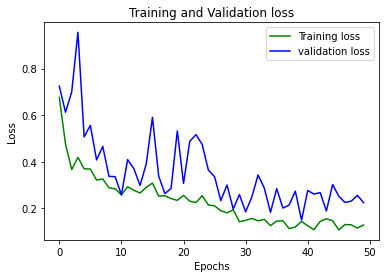

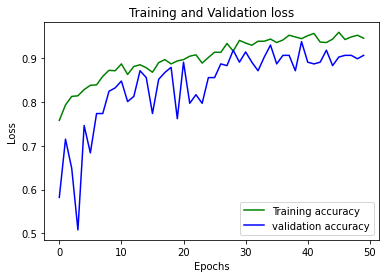

In [16]:
import matplotlib.pyplot as plt

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




# New Section